In [13]:
import torch
import os, pickle
import numpy as np
import evaluate
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
from torchinfo import summary
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch import nn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tqdm.notebook import tqdm
from matplotlib.colors import ListedColormap, BoundaryNorm

In [41]:
base_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0")

config = base_model.config
config.num_channels = 18
config.num_labels = 2
config.hidden_dropout_prob = 0.2
config.classifier_dropout_prob = 0.2
model = SegformerForSemanticSegmentation(config)

# Added batch size to input_size
summary(model, input_size=(1, 18, 128, 128))

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer (type:depth-idx)                                                      Output Shape              Param #
SegformerForSemanticSegmentation                                            [1, 2, 32, 32]            --
├─SegformerModel: 1-1                                                       [1, 32, 32, 32]           --
│    └─SegformerEncoder: 2-1                                                [1, 32, 32, 32]           --
│    │    └─ModuleList: 3-10                                                --                        (recursive)
│    │    └─ModuleList: 3-11                                                --                        (recursive)
│    │    └─ModuleList: 3-12                                                --                        (recursive)
│    │    └─ModuleList: 3-10                                                --                        (recursive)
│    │    └─ModuleList: 3-11                                                --                        (recursive)
│    

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_input  = torch.randn(1, 18, 128, 128)

output = model(test_input)

print(output.logits.shape)

torch.Size([1, 2, 32, 32])


In [17]:
import os
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset

def get_indices(arr):
    if arr.ndim != 3 or arr.shape[2] < 7:
        raise ValueError("Input array must be 3-dimensional with at least 7 channels.")
    
    bands = {
        "ndvi": (arr[:, :, 4] - arr[:, :, 3]) / (arr[:, :, 4] + arr[:, :, 3] + 1e-7),
        "evi": 2.5 * (arr[:, :, 4] - arr[:, :, 3]) / (arr[:, :, 4] + 6 * arr[:, :, 3] - 7.5 * arr[:, :, 1] + 1),
        "savi": 1.5 * (arr[:, :, 4] - arr[:, :, 3]) / (arr[:, :, 4] + arr[:, :, 3] + 0.5),
        "msavi": 0.5 * (2 * arr[:, :, 4] + 1 - np.sqrt((2 * arr[:, :, 4] + 1) ** 2 - 8 * (arr[:, :, 4] - arr[:, :, 3]))),
        "ndmi": (arr[:, :, 4] - arr[:, :, 5]) / (arr[:, :, 4] + arr[:, :, 5] + 1e-7),
        "nbr": (arr[:, :, 4] - arr[:, :, 6]) / (arr[:, :, 4] + arr[:, :, 6] + 1e-7),
        "nbr2": (arr[:, :, 5] - arr[:, :, 6]) / (arr[:, :, 5] + arr[:, :, 6] + 1e-7),
    }
    for name in bands:
        value = np.nan_to_num(bands[name])
        arr = np.dstack((arr, value))
    return arr

class SlidingWindowDataset(Dataset):
    def __init__(self, pickle_dir, window_size=128, stride=64, reduce_indices=False):
        self.pickle_dir = pickle_dir
        self.window_size = window_size
        self.stride = stride
        self.reduce_indices = reduce_indices
        self.processed_images, self.processed_masks = self._process_data()

    def _process_data(self):
        processed_images = []
        processed_masks = []
        
        for file_name in os.listdir(self.pickle_dir):
            if file_name.endswith('.pkl'):
                with open(os.path.join(self.pickle_dir, file_name), 'rb') as f:
                    img, mask = pickle.load(f, encoding='latin1')
                
                if img.ndim == 3 and img.shape[2] >= 7:
                    img = get_indices(img)
                    h, w, _ = img.shape
                    for i in range(0, h - self.window_size + 1, self.stride):
                        for j in range(0, w - self.window_size + 1, self.stride):
                            window_img = img[i:i + self.window_size, j:j + self.window_size]
                            window_mask = mask[i:i + self.window_size, j:j + self.window_size]
                            class_0_ratio = np.sum(window_mask == 0) / window_mask.size
                            class_1_ratio = np.sum(window_mask == 1) / window_mask.size
                            class_2_ratio = np.sum(window_mask == 2) / window_mask.size
                            if class_0_ratio < 0.5:
                                if class_2_ratio > 0.4:
                                    # Augment the image by rotating it 90 degrees 3 times
                                    for _ in range(3):
                                        window_img = np.rot90(window_img)
                                        window_mask = np.rot90(window_mask)
                                        processed_images.append(window_img)
                                        processed_masks.append(window_mask)
                                else:
                                    processed_images.append(window_img)
                                    processed_masks.append(window_mask)

                else:
                    print(f"Skipping image with shape {img.shape} in file {file_name}")
        
        return processed_images, processed_masks

    def __len__(self):
        return len(self.processed_images)

    def __getitem__(self, idx):
        image = self.processed_images[idx]
        mask = self.processed_masks[idx]
        
        if mask.dtype == np.uint16:
            mask = mask.astype(np.int64)
            
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Convert to CxHxW
        mask = torch.tensor(mask, dtype=torch.long)
        
        if self.reduce_indices:
            mask = mask - 1
            mask[mask == -1] = 255

        encoded_data = {
            'pixel_values': image,
            'labels': mask
        }

        return encoded_data

In [18]:
root_dir = 'data/train/training_2015_pickled_data'

dataset = SlidingWindowDataset(pickle_dir=root_dir, window_size=128, reduce_indices=True)

SEED = 123
LEARNING_RATE = 1e-5
BATCH_SIZE = 16
TRAIN_DEV_TEST_SPLIT = (0.8, 0.1, 0.1)

generator = torch.Generator().manual_seed(SEED)
train_dataset, val_dataset, test_dataset = random_split(dataset, TRAIN_DEV_TEST_SPLIT, generator)

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [19]:
batch = next(iter(train_dataloader))

In [20]:
# Take a mask and check if it has any values other than 0 and 1
mask = batch['labels']
image = batch['pixel_values']

print(torch.unique(mask))
print(mask.shape)
print(image.shape)

tensor([  0,   1, 255])
torch.Size([16, 128, 128])
torch.Size([16, 18, 128, 128])


In [21]:
# Take a mask and check if it has any values other than 0 and 1
mask = batch['labels']

print(torch.unique(mask))

tensor([  0,   1, 255])


In [22]:
print(len(dataset))

#3321

692


In [37]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the metric functions
def compute_accuracy_ignore_background(preds, labels, ignore_index=255):
    preds = preds.cpu().numpy().flatten()
    labels = labels.cpu().numpy().flatten()
    mask = labels != ignore_index
    preds = preds[mask]
    labels = labels[mask]
    accuracy = (preds == labels).mean()
    return accuracy

def compute_miou_ignore_background(preds, labels, num_classes, ignore_index=255):
    preds = preds.cpu().numpy().flatten()
    labels = labels.cpu().numpy().flatten()
    mask = labels != ignore_index
    preds = preds[mask]
    labels = labels[mask]
    
    ious = []
    for cls in range(num_classes):
        if cls == ignore_index:
            continue
        pred_inds = preds == cls
        label_inds = labels == cls
        intersection = np.logical_and(pred_inds, label_inds).sum()
        union = np.logical_or(pred_inds, label_inds).sum()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)

def compute_precision_per_class_ignore_background(preds, labels, num_classes, ignore_index=255):
    preds = preds.cpu().numpy().flatten()
    labels = labels.cpu().numpy().flatten()
    mask = labels != ignore_index
    preds = preds[mask]
    labels = labels[mask]
    
    precision_per_class = precision_score(labels, preds, average=None, labels=range(num_classes), zero_division=0)
    return {f'class_{i}': precision for i, precision in enumerate(precision_per_class) if i != ignore_index}

def compute_recall_per_class_ignore_background(preds, labels, num_classes, ignore_index=255):
    preds = preds.cpu().numpy().flatten()
    labels = labels.cpu().numpy().flatten()
    mask = labels != ignore_index
    preds = preds[mask]
    labels = labels[mask]
    
    recall_per_class = recall_score(labels, preds, average=None, labels=range(num_classes), zero_division=0)
    return {f'class_{i}': recall for i, recall in enumerate(recall_per_class) if i != ignore_index}

def compute_f1_per_class_ignore_background(preds, labels, num_classes, ignore_index=255):
    preds = preds.cpu().numpy().flatten()
    labels = labels.cpu().numpy().flatten()
    mask = labels != ignore_index
    preds = preds[mask]
    labels = labels[mask]
    
    f1_per_class = f1_score(labels, preds, average=None, labels=range(num_classes), zero_division=0)
    return {f'class_{i}': f1 for i, f1 in enumerate(f1_per_class) if i != ignore_index}

# Initialize the exponentially weighted average loss
ewma_loss = None
alpha = 0.1  # Smoothing factor

model.train()
for epoch in range(10):  # loop over the dataset multiple times
    losses = []
    accuracies = []
    mious = []
    precisions = []
    recalls = []
    f1_scores = []
    print("Epoch:", epoch)
    t = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for idx, batch in t:
        # Get the inputs
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # Update the exponentially weighted average loss
        if ewma_loss is None:
            ewma_loss = loss.item()
        else:
            ewma_loss = alpha * loss.item() + (1 - alpha) * ewma_loss

        # Evaluate
        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)

            # Calculate metrics
            accuracy = compute_accuracy_ignore_background(predicted, labels)
            miou = compute_miou_ignore_background(predicted, labels, num_classes=2)
            precision_per_class = compute_precision_per_class_ignore_background(predicted, labels, num_classes=2)
            recall_per_class = compute_recall_per_class_ignore_background(predicted, labels, num_classes=2)
            f1_per_class = compute_f1_per_class_ignore_background(predicted, labels, num_classes=2)

        losses.append(loss.item())
        accuracies.append(accuracy)
        mious.append(miou)
        precisions.append(precision_per_class)
        recalls.append(recall_per_class)
        f1_scores.append(f1_per_class)

        # Print loss and metrics every batch
        t.set_postfix(Loss=f"{ewma_loss:.4f}", Accuracy=f"{accuracy:.4f}", mIoU=f"{miou:.4f}")
        t.update()

    # Print loss and metrics every epoch
    print(f"Loss: {np.mean(losses):.4f}, Accuracy: {np.mean(accuracies):.4f}, mIoU: {np.nanmean(mious):.4f}")
    print(f"Precision: {np.nanmean([list(p.values()) for p in precisions], axis=0)}")
    print(f"Recall: {np.nanmean([list(r.values()) for r in recalls], axis=0)}")
    print(f"F1 Score: {np.nanmean([list(f.values()) for f in f1_scores], axis=0)}")

Epoch: 0


100%|██████████| 35/35 [00:49<00:00,  1.41s/it, Accuracy=0.6956, Loss=0.6235, mIoU=0.5323]


Loss: 0.6269, Accuracy: 0.6493, mIoU: 0.4802
Precision: [0.65075006 0.65010115]
Recall: [0.67326477 0.62562668]
F1 Score: [0.66015728 0.63590785]
Epoch: 1


100%|██████████| 35/35 [00:49<00:00,  1.40s/it, Accuracy=0.6611, Loss=0.6185, mIoU=0.4912]


Loss: 0.6218, Accuracy: 0.6546, mIoU: 0.4863
Precision: [0.65737934 0.65222331]
Recall: [0.67255589 0.63702817]
F1 Score: [0.66364761 0.64326925]
Epoch: 2


100%|██████████| 35/35 [00:49<00:00,  1.41s/it, Accuracy=0.6338, Loss=0.6250, mIoU=0.4632]


Loss: 0.6206, Accuracy: 0.6565, mIoU: 0.4885
Precision: [0.65670062 0.65676834]
Recall: [0.67743043 0.63520889]
F1 Score: [0.66601572 0.64485481]
Epoch: 3


100%|██████████| 35/35 [00:49<00:00,  1.41s/it, Accuracy=0.6555, Loss=0.6253, mIoU=0.4875]


Loss: 0.6182, Accuracy: 0.6597, mIoU: 0.4920
Precision: [0.66244795 0.65688933]
Recall: [0.67250532 0.64610119]
F1 Score: [0.66681645 0.6507599 ]
Epoch: 4


100%|██████████| 35/35 [00:47<00:00,  1.37s/it, Accuracy=0.6439, Loss=0.6180, mIoU=0.4748]


Loss: 0.6185, Accuracy: 0.6567, mIoU: 0.4887
Precision: [0.65726932 0.65747032]
Recall: [0.67997357 0.6337526 ]
F1 Score: [0.66738021 0.64424355]
Epoch: 5


100%|██████████| 35/35 [00:48<00:00,  1.37s/it, Accuracy=0.6493, Loss=0.6207, mIoU=0.4799]


Loss: 0.6179, Accuracy: 0.6586, mIoU: 0.4907
Precision: [0.66319901 0.65357044]
Recall: [0.66906063 0.64798059]
F1 Score: [0.66540132 0.65003898]
Epoch: 6


100%|██████████| 35/35 [00:49<00:00,  1.41s/it, Accuracy=0.6288, Loss=0.6187, mIoU=0.4584]


Loss: 0.6167, Accuracy: 0.6575, mIoU: 0.4896
Precision: [0.65983519 0.65598585]
Recall: [0.67536588 0.6400399 ]
F1 Score: [0.66644435 0.64676373]
Epoch: 7


100%|██████████| 35/35 [00:51<00:00,  1.46s/it, Accuracy=0.5978, Loss=0.6193, mIoU=0.4262]


Loss: 0.6142, Accuracy: 0.6616, mIoU: 0.4942
Precision: [0.66205857 0.6622744 ]
Recall: [0.68195829 0.64177436]
F1 Score: [0.67073813 0.65075026]
Epoch: 8


100%|██████████| 35/35 [00:47<00:00,  1.36s/it, Accuracy=0.6763, Loss=0.6117, mIoU=0.5103]


Loss: 0.6132, Accuracy: 0.6624, mIoU: 0.4947
Precision: [0.66277643 0.66248633]
Recall: [0.68268471 0.64246267]
F1 Score: [0.67150793 0.65119793]
Epoch: 9


100%|██████████| 35/35 [00:47<00:00,  1.37s/it, Accuracy=0.6881, Loss=0.6083, mIoU=0.5239]

Loss: 0.6098, Accuracy: 0.6656, mIoU: 0.4987
Precision: [0.67208881 0.65987551]
Recall: [0.66846501 0.66296178]
F1 Score: [0.66927145 0.66039854]


In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate on the validation set
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        all_preds.append(predicted.detach().cpu())
        all_labels.append(labels.detach().cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Flatten the tensors
all_preds_flat = all_preds.flatten()
all_labels_flat = all_labels.flatten()

# Mask to ignore the ignore_index
ignore_index = 255
mask = all_labels_flat != ignore_index

# Filter out the ignore_index
filtered_preds = all_preds_flat[mask]
filtered_labels = all_labels_flat[mask]

print("Accuracy:", accuracy_score(filtered_labels, filtered_preds))

precision = precision_score(filtered_labels, filtered_preds, average=None, zero_division=0)
recall = recall_score(filtered_labels, filtered_preds, average=None, zero_division=0)
f1 = f1_score(filtered_labels, filtered_preds, average=None, zero_division=0)

for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f"Class {i} - Precision: {p}, Recall: {r}, F1 score: {f}")

100%|██████████| 5/5 [00:01<00:00,  3.50it/s]


Accuracy: 0.5804227628292644
Class 0 - Precision: 0.5651365262815484, Recall: 0.7765628314054484, F1 score: 0.6541912962325809
Class 1 - Precision: 0.6164772641796119, Recall: 0.3754069796203295, F1 score: 0.46664692820133236


100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


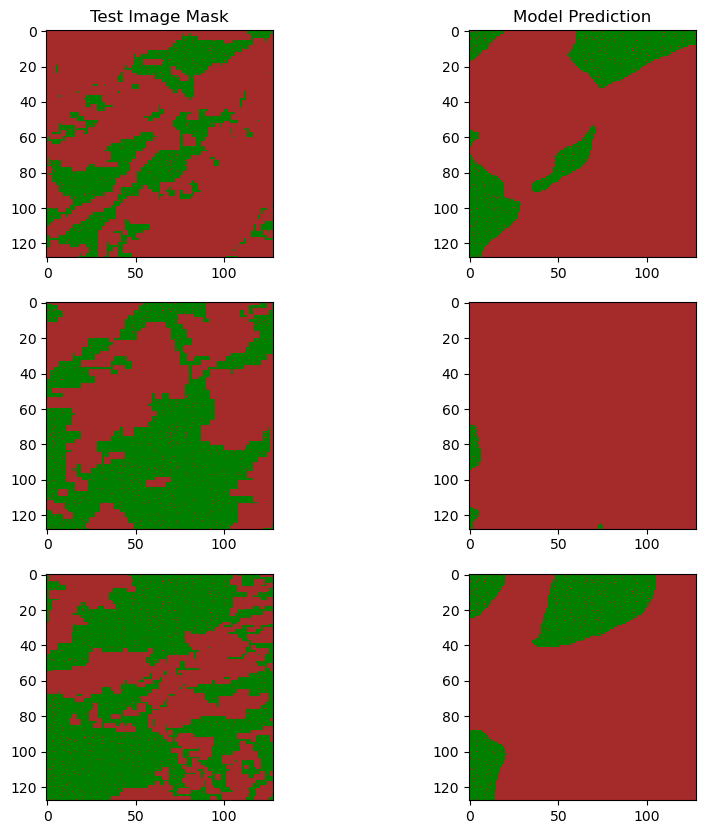

In [40]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        # Set predictions to 255 wherever the ignore class is present in the labels
        predicted[labels == 255] = 255

        all_preds.append(predicted.detach().cpu())
        all_labels.append(labels.detach().cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Flatten the tensors
all_preds_flat = all_preds.flatten()
all_labels_flat = all_labels.flatten()

# Mask to ignore the ignore_index
ignore_index = 255
mask = all_labels_flat != ignore_index

# Filter out the ignore_index
filtered_preds = all_preds_flat[mask]
filtered_labels = all_labels_flat[mask]

# Define the colors for each specific value
colors = ['brown', 'green', 'black']

# Create a colormap
cmap = ListedColormap(colors)

# Define the boundaries for the values
boundaries = [0, 1, 2, 3]  # 0-1 -> black, 1-2 -> brown, 2-3 -> green

# Create a normalization
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

# Plot a test image mask and the model's prediction
idx = 4
rows = 3

fig, ax = plt.subplots(rows, 2, figsize=(10, 10))

ax[0][0].set_title("Test Image Mask")
ax[0][1].set_title("Model Prediction")
for i in range(rows):
    ax[i][0].imshow(all_labels[idx * rows + i], cmap=cmap, norm=norm)
    ax[i][1].imshow(all_preds[idx * rows + i], cmap=cmap, norm=norm)

plt.show()

In [ ]:
all_preds[idx]

In [ ]:
model_list = os.listdir('Model')

# Get the last number of the model
model_list = sorted(model_list, key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Save the model with the next number

MODEL_SAVE_PATH = f"Model/model_{int(model_list[-1].split('_')[-1].split('.')[0]) + 1}.pth"

In [ ]:
# load model

model_num = 1

model = SegformerForSemanticSegmentation.from_pretrained(f"Model/model_{model_num}.pth")